# <center>**Social Search on r/advice**</center>

# **REDDIT DATASET CONSTRUCTION**

## CREATION of *posts* and *comments* DATASET

```
import random
import time
import pandas as pd
import praw
import prawcore

posts_data = []
comments_data = []

submissions = reddit.subreddit("advice").top(limit=None)

for submission in submissions:
    if submission.num_comments <= 16:
        continue

    try:
        submission.comments.replace_more(limit=0)
    except prawcore.exceptions.TooManyRequests as e:
        time.sleep(e.sleep_time)
        continue
    except Exception as e:
        continue

    top_level_comments = [c for c in submission.comments if c.is_root and c.ups >= 10 and c.ups <= 150]

    if len(top_level_comments) <= 16:
        continue

    posts_data.append({
        "post_id": submission.id,
        "post_title": submission.title,
        "post_description": submission.selftext
    })

    sampled_comments = random.sample(top_level_comments, 16)

    for comment in sampled_comments:
        try:
            comments_data.append({
                "comment_id": f"{submission.id}_{comment.id}",
                "text": comment.body,
                "upvotes": comment.ups,
                "replies": len(comment.replies),
                "timestamp": comment.created_utc,
                "karma_post": getattr(submission.author, "link_karma", None),
                "karma_comments": getattr(comment.author, "comment_karma", None)
            })
        except Exception as e:
            continue

    time.sleep(2)

    if len(posts_data) >= 200:
        break

df_posts = pd.DataFrame(posts_data)
df_comments = pd.DataFrame(comments_data)

df_posts.to_csv("advice_titles_prov2.csv", index=False, encoding="utf-8")
df_comments.to_csv("advice_comments_prov2.csv", index=False, encoding="utf-8")
```

This cell has been run only once, to avoid having different datasets every time the code is executed. The results were then stored in csv files to be loaded later

In [ ]:
%pip install rank_bm25

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from wordcloud import WordCloud
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk

from rank_bm25 import BM25Okapi
from sklearn.preprocessing import MinMaxScaler
from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn.functional as F
from tqdm import tqdm

## LOADING *posts* DATASET

In [ ]:
df_posts = pd.read_csv('/content/advice_posts_def.csv')

In [ ]:
df_posts.head()

,post_id,post_text,post_description
0,1izle46,My Dad Left Us 15 Years Ago – Now He’s Dying a...,"When I was 10, my dad walked out on our family..."
1,1j6z84l,Girlfriend just punched me in the face multipl...,So my longtime girlfriend just had an absolute...
2,1hq4eut,My GF is in a medically induced coma and I am ...,\nMy (34M) girlfriend (35F) started having chi...
3,1jxjlxv,Professor has been secretly docking points any...,My professor recently revealed that he’s been ...
4,1le1rhl,Gf gave me chlamydia,Gf of 6 months just tested positive for chlamy...


In [ ]:
df_posts.shape

(165, 3)

##  LOADING *comments* DATASET

In [ ]:
df_comments = pd.read_csv('/content/advice_comments_def.csv').drop(columns=["Unnamed: 0"])

In [ ]:
df_comments.head()

,comment_id,text,upvotes,replies,timestamp,karma_post,karma_comments
0,1izle46_mf3ts7q,"Meh. Fuck him. For those who sow in flames, in...",17,0,1.740679e+09,8067.0,23664.0
1,1izle46_mf3whj8,So my dad bailed when I was only a year old. I...,33,4,1.740679e+09,8067.0,35002.0
2,1izle46_mf3u270,Absolutely not. Mine did the same. Classic cas...,38,0,1.740679e+09,8067.0,2141.0
3,1izle46_mf3sncb,"You don't owe him anything, that's for sure, b...",30,1,1.740678e+09,8067.0,7914.0
4,1izle46_mf3sxrc,My dad did the same thing when I was 7. If I g...,122,7,1.740678e+09,8067.0,122650.0


In [ ]:
df_comments.shape

(2640, 7)

##  CREATION of *qrels* DATASET

In [ ]:
df_qrels = df_comments.copy()

In [ ]:
df_qrels = df_qrels.drop(columns=['replies', 'timestamp', 'karma_post', 'karma_comments', 'text'])

In [ ]:
df_qrels['post_id'] = df_qrels['comment_id'].apply(lambda x: x.split('_')[0])
df_qrels.insert(0, 'post_id', df_qrels.pop('post_id'))
df_qrels.head()

,post_id,comment_id,upvotes
0,1izle46,1izle46_mf3ts7q,17
1,1izle46,1izle46_mf3whj8,33
2,1izle46,1izle46_mf3u270,38
3,1izle46,1izle46_mf3sncb,30
4,1izle46,1izle46_mf3sxrc,122


Rank comments using the Wilson score to balance high upvote ratios with vote count.
* Balances upvote ratio with total votes

* Penalizes low-vote, high-ratio comments

* Rewards consistently upvoted comments over time

* Based on 95% confidence interval (z = 1.96)

In [ ]:
def calculate_wilson_score(df, z=1.96):
    def wilson_score(upvotes, total_votes, z=1.96):
        if total_votes == 0:
            return 0
        phat = upvotes / total_votes
        numerator = phat + z*z/(2*total_votes) - z * ((phat*(1-phat) + z*z/(4*total_votes)) / total_votes)**0.5
        denominator = 1 + z*z / total_votes
        return numerator / denominator

    if "post_id" not in df.columns:
        df["post_id"] = df["comment_id"].str.split("_").str[0]

    wilson_scores = []

    for i, row in df.iterrows():
        post_id = row["post_id"]
        upvotes = row["upvotes"]
        total_votes = df[df["post_id"] == post_id]["upvotes"].sum()
        score = wilson_score(upvotes, total_votes, z)
        wilson_scores.append(score)

    df["wilson_score_raw"] = wilson_scores

    df["wilson_score"] = df.groupby("post_id")["wilson_score_raw"].transform(lambda x: x / x.max())

    df.drop(columns=["wilson_score_raw"], inplace=True)

    return df

In [ ]:
calculate_wilson_score(df_qrels)

,post_id,comment_id,upvotes,wilson_score
0,1izle46,1izle46_mf3ts7q,17,0.096100
1,1izle46,1izle46_mf3whj8,33,0.213139
2,1izle46,1izle46_mf3u270,38,0.251247
3,1izle46,1izle46_mf3sncb,30,0.190552
4,1izle46,1izle46_mf3sxrc,122,0.932859
...,...,...,...,...
2635,1lpyp0w,1lpyp0w_n0zdqao,22,0.174746
2636,1lpyp0w,1lpyp0w_n0zdrsw,15,0.109167
2637,1lpyp0w,1lpyp0w_n0zhoa7,41,0.364747
2638,1lpyp0w,1lpyp0w_n0yk03w,14,0.100128


In [ ]:
mean_wilson_score = df_qrels['wilson_score'].mean()

print(f"The mean of wilson scores is: {mean_wilson_score}")

The mean of wilson scores is: 0.29026570215981917


In [ ]:
median_wilson_score = df_qrels['wilson_score'].median()

print(f"The median of wilson scores: {median_wilson_score}")

The median of wilson scores: 0.16391872819869122


We assign a relevance level (1–4) to each comment using its Wilson score within the same post_id group.
This is done by computing quantiles (Q1, Q2, Q3) for each group and assigning levels as follows:
* Score ≤ Q1 → low relevance

* Q1 < Score ≤ Q2 → moderate relevance

* Q2 < Score ≤ Q3 → high relevance

* Score > Q3 → top relevance

In [ ]:
def assign_relevance_level(df):
    df['relevance_level'] = df.groupby('post_id')['wilson_score'].transform(
        lambda x: pd.qcut(x, q=[0, 0.25, 0.5, 0.75, 1], labels=[1, 2, 3, 4], duplicates='drop')
    )
    return df

df_qrels = assign_relevance_level(df_qrels)

To ensure a balanced and representative set of relevance judgments, we select a fixed number of top comments per relevance level (1–4) within each post. The selection is based on upvote count within each level:

*    Level 4 → top 2 comments

*    Level 3 → top 3 comments

*    Level 2 → top 3 comments

*    Level 1 → top 2 comments

The final result is stored in *df_qrels_fin*.

In [ ]:
df_qrels_fin = pd.DataFrame()

for post_id in df_qrels['post_id'].unique():
    df_query = df_qrels[df_qrels['post_id'] == post_id].copy()

    comments_level_4 = df_query[df_query['relevance_level'] == 4].sort_values(by='upvotes', ascending=False).head(2)
    comments_level_3 = df_query[df_query['relevance_level'] == 3].sort_values(by='upvotes', ascending=False).head(3)
    comments_level_2 = df_query[df_query['relevance_level'] == 2].sort_values(by='upvotes', ascending=False).head(3)
    comments_level_1 = df_query[df_query['relevance_level'] == 1].sort_values(by='upvotes', ascending=False).head(2)

    selected_for_query = pd.concat([comments_level_4, comments_level_3, comments_level_2, comments_level_1])

    df_qrels_fin = pd.concat([df_qrels_fin, selected_for_query])

df_qrels_fin.reset_index(drop=True, inplace=True)

In [ ]:
df_qrels_fin.head()

,post_id,comment_id,upvotes,wilson_score,relevance_level
0,1izle46,1izle46_mf3scgz,130,1.000000,4
1,1izle46,1izle46_mf3sxrc,122,0.932859,4
2,1izle46,1izle46_mf3sqs6,51,0.352430,3
3,1izle46,1izle46_mf3sxto,49,0.336698,3
4,1izle46,1izle46_mf3tkf1,48,0.328852,3


In [ ]:
df_qrels_fin.shape

(1650, 5)

# **EXPLORATIVE DATA ANALYSIS**

## DISTRIBUTION OF POSTS LENGTHS (IN WORDS)

### TITLE

This code calculates the length of each title in post in words and plots a histogram with a KDE curve to show the distribution of post title lengths.

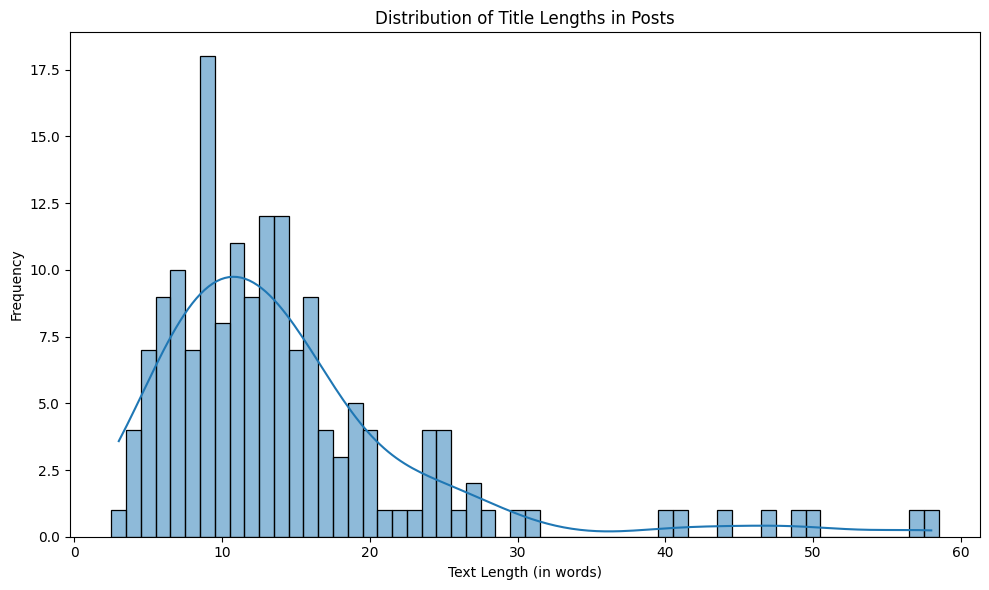

In [ ]:
df_posts_exploration_title = df_posts.copy()

df_posts_exploration_title['text_length'] = df_posts_exploration_title['post_text'].str.split().str.len()  # in words

plt.figure(figsize=(10, 6))
bins = range(df_posts_exploration_title['text_length'].min(), df_posts_exploration_title['text_length'].max() + 1)
sns.histplot(df_posts_exploration_title['text_length'], bins=bins, kde=True, discrete=True)

plt.title('Distribution of Title Lengths in Posts')
plt.xlabel('Text Length (in words)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


Here we calculate the minimum and maximum Post_title lengths (in words), counts how many responses have those lengths, and prints the results.

In [ ]:
min_len = df_posts_exploration_title['text_length'].min()
max_len = df_posts_exploration_title['text_length'].max()

num_min = (df_posts_exploration_title['text_length'] == min_len).sum()
num_max = (df_posts_exploration_title['text_length'] == max_len).sum()

print(f"Minimum length (in words): {min_len} -> {num_min} queries")
print(f"Maximum length (in words): {max_len} -> {num_max} queries")

Minimum length (in words): 3 -> 1 queries
Maximum length (in words): 58 -> 1 queries


### DESCRIPTION

This code calculates the length of each description in post in words and plots a histogram with a KDE curve to show the distribution of post descritpion lengths.

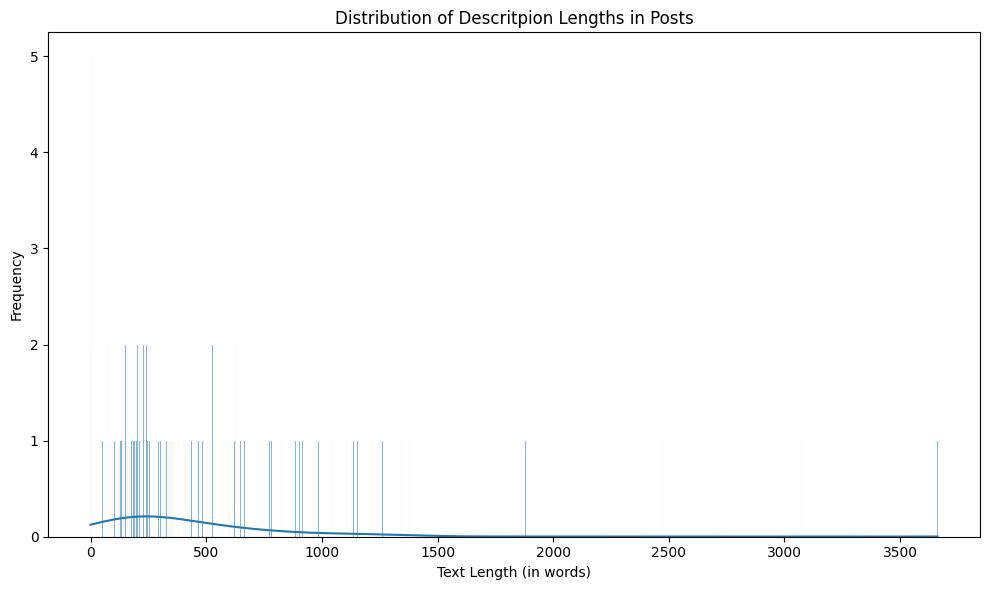

In [ ]:
df_posts_exploration_descr = df_posts.copy()

df_posts_exploration_descr['post_description'] = df_posts_exploration_descr['post_description'].fillna('')

df_posts_exploration_descr['text_length'] = df_posts_exploration_descr['post_description'].str.split().str.len()

min_len = int(df_posts_exploration_descr['text_length'].min())
max_len = int(df_posts_exploration_descr['text_length'].max()) + 1
bins = range(min_len, max_len)

plt.figure(figsize=(10, 6))
sns.histplot(df_posts_exploration_descr['text_length'], bins=bins, kde=True, discrete=True)

plt.title('Distribution of Descritpion Lengths in Posts')
plt.xlabel('Text Length (in words)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

Here we calculate the minimum and maximum Post_descritpion lengths (in words), counts how many responses have those lengths, and prints the results.

In [ ]:
min_len = df_posts_exploration_descr['text_length'].min()
max_len = df_posts_exploration_descr['text_length'].max()

num_min = (df_posts_exploration_descr['text_length'] == min_len).sum()
num_max = (df_posts_exploration_descr['text_length'] == max_len).sum()

print(f"Minimum length (in words): {min_len} -> {num_min} post (descritpion)")
print(f"Maximum length (in words): {max_len} -> {num_max} post (descritpion)")

Minimum length (in words): 0 -> 5 post (descritpion)
Maximum length (in words): 3662 -> 1 post (descritpion)


## DISTRIBUTION OF COMMENTS LENGTHS (IN WORDS)

This code calculates the length of each comment in words and plots a histogram with a KDE curve to show the distribution of response lengths.

Text(0, 0.5, 'Frequency')

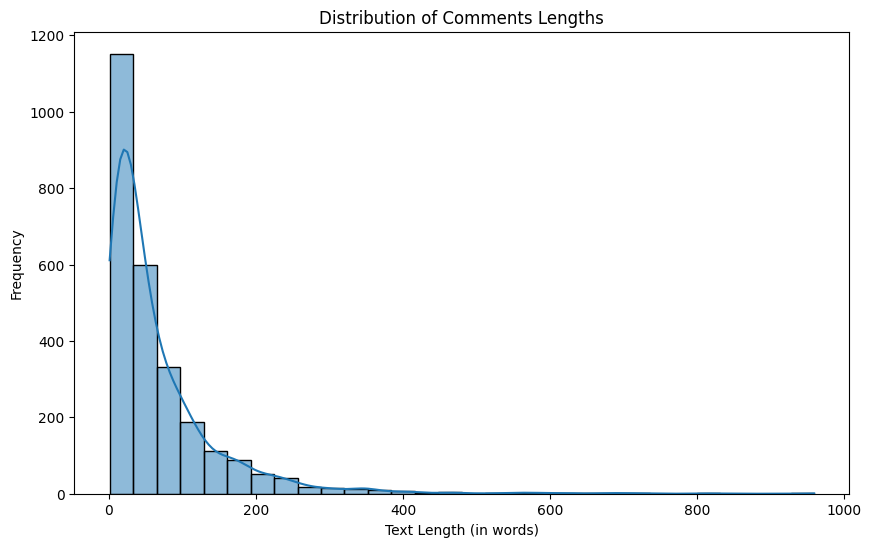

In [ ]:
df_comments_exploration = df_comments.copy()

df_comments_exploration['text_length'] = df_comments_exploration['text'].str.split().str.len()  # in words

plt.figure(figsize=(10, 6))
sns.histplot(df_comments_exploration['text_length'], bins=30, kde=True)

plt.title('Distribution of Comments Lengths')
plt.xlabel('Text Length (in words)')
plt.ylabel('Frequency')

Here we calculate the minimum and maximum response lengths (in words), counts how many responses have those lengths, and prints the results.

In [ ]:
min_len = df_comments_exploration['text_length'].min()
max_len = df_comments_exploration['text_length'].max()

num_min = (df_comments_exploration['text_length'] == min_len).sum()
num_max = (df_comments_exploration['text_length'] == max_len).sum()

print(f"Minimum length (in words): {min_len} -> {num_min} responses")
print(f"Maximum length (in words): {max_len} -> {num_max} responses")

Minimum length (in words): 1 -> 84 responses
Maximum length (in words): 959 -> 1 responses


## TOP WORD FREQUENCY IN POSTS (EXCLUDING STOP WORDS)

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

### TITLE

This code concatenates all posts title texts, tokenizes and cleans them by removing punctuation and stopwords, then counts and prints the 20 most frequent words.

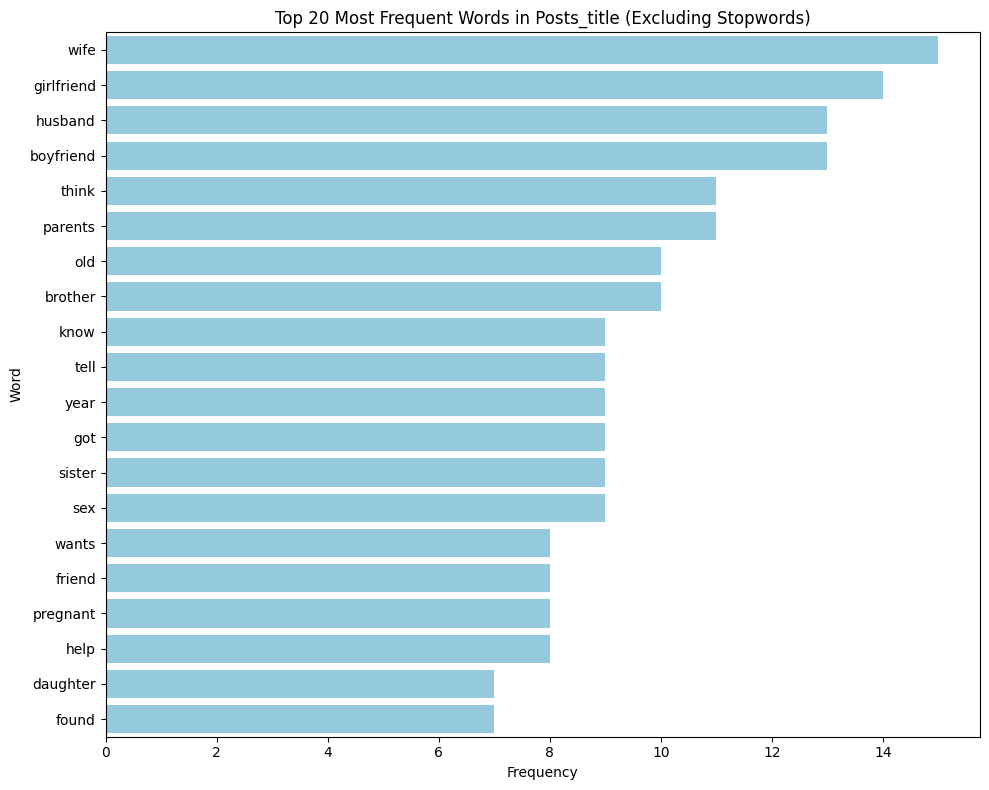

In [ ]:
all_text = ' '.join(df_posts['post_text'].astype(str))

tokens = word_tokenize(all_text.lower())
stop_words = set(stopwords.words('english'))
tokens_cleaned = [word for word in tokens if word.isalpha() and word not in stop_words]

word_freq = Counter(tokens_cleaned)
top_words = word_freq.most_common(20)

words, freqs = zip(*top_words)
plt.figure(figsize=(10, 8))
sns.barplot(x=list(freqs), y=list(words), color='skyblue')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.title('Top 20 Most Frequent Words in Posts_title (Excluding Stopwords)')
plt.tight_layout()
plt.show()

### DESCRIPTION

This code concatenates all posts description texts, tokenizes and cleans them by removing punctuation and stopwords, then counts and prints the 20 most frequent words.

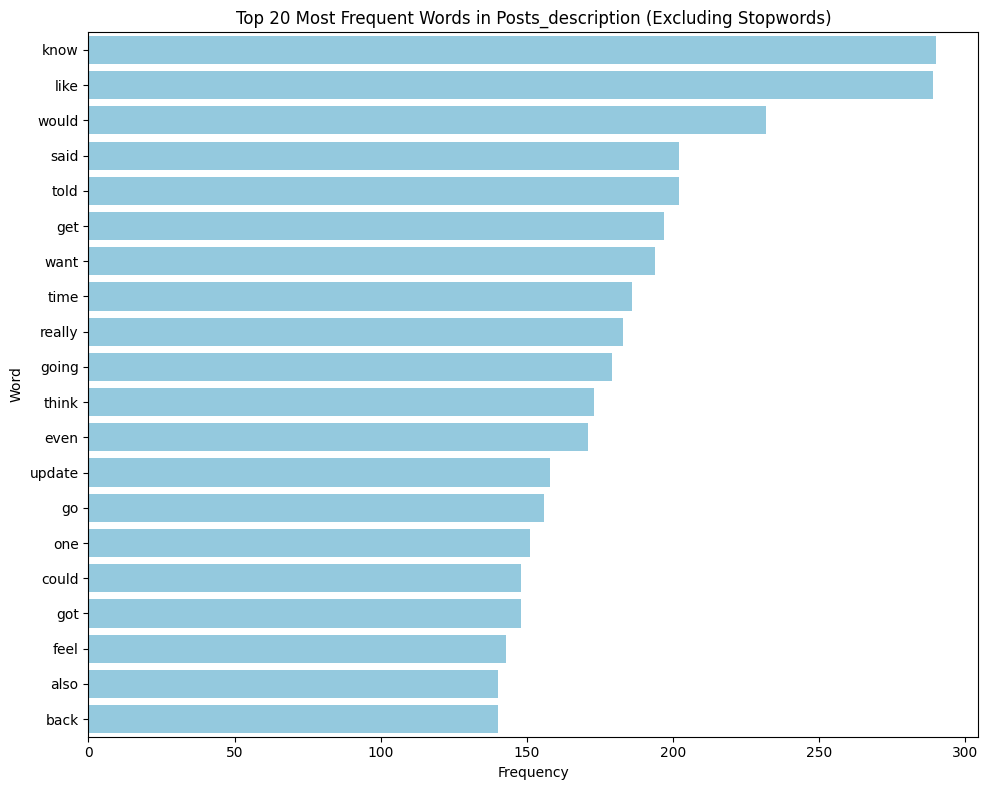

In [ ]:
all_text = ' '.join(df_posts['post_description'].astype(str))

tokens = word_tokenize(all_text.lower())
stop_words = set(stopwords.words('english'))
tokens_cleaned = [word for word in tokens if word.isalpha() and word not in stop_words]

word_freq = Counter(tokens_cleaned)
top_words = word_freq.most_common(20)

words, freqs = zip(*top_words)
plt.figure(figsize=(10, 8))
sns.barplot(x=list(freqs), y=list(words), color='skyblue')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.title('Top 20 Most Frequent Words in Posts_description (Excluding Stopwords)')
plt.tight_layout()
plt.show()

## TOP WORD FREQUENCY IN COMMENTS (EXCLUDING STOP WORDS)

This code concatenates all comments texts, tokenizes and cleans them by removing punctuation and stopwords, then counts and prints the 20 most frequent words.

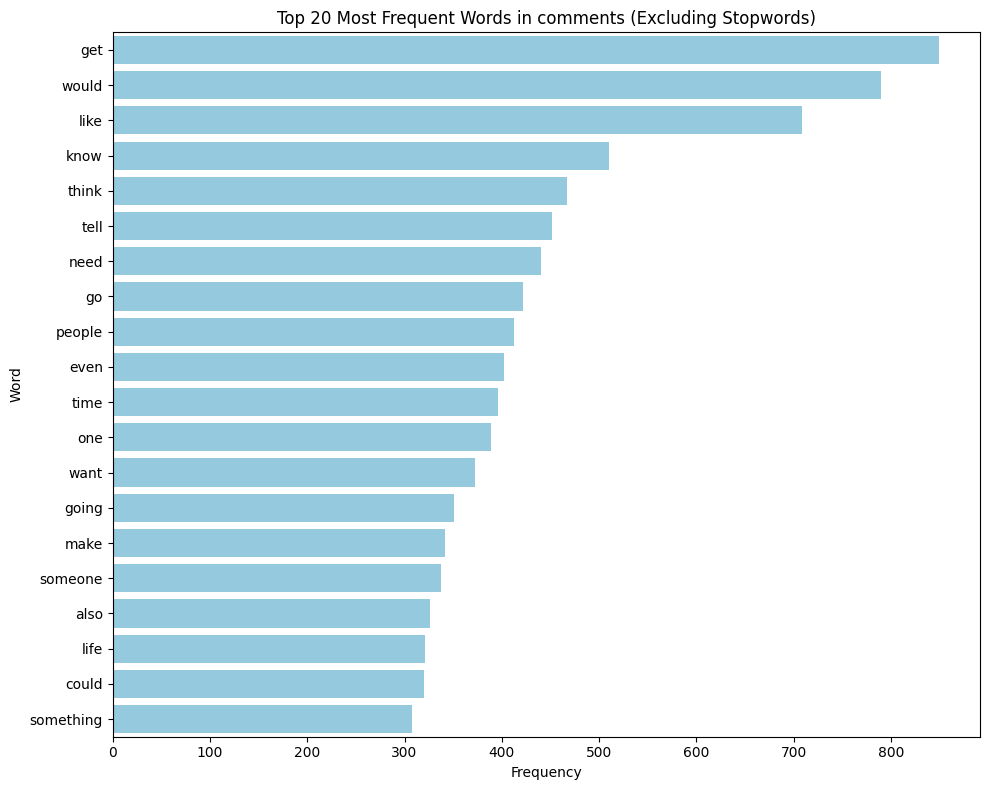

In [ ]:
all_text = ' '.join(df_comments['text'].astype(str))

tokens = word_tokenize(all_text.lower())
stop_words = set(stopwords.words('english'))
tokens_cleaned = [word for word in tokens if word.isalpha() and word not in stop_words]

word_freq = Counter(tokens_cleaned)
top_words = word_freq.most_common(20)

words, freqs = zip(*top_words)

plt.figure(figsize=(10, 8))
sns.barplot(x=list(freqs), y=list(words), color='skyblue')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.title('Top 20 Most Frequent Words in comments (Excluding Stopwords)')
plt.tight_layout()

plt.show()


## CORRELATION MATRIX: COMMENT FEATURES AND RELEVANCE LEVEL

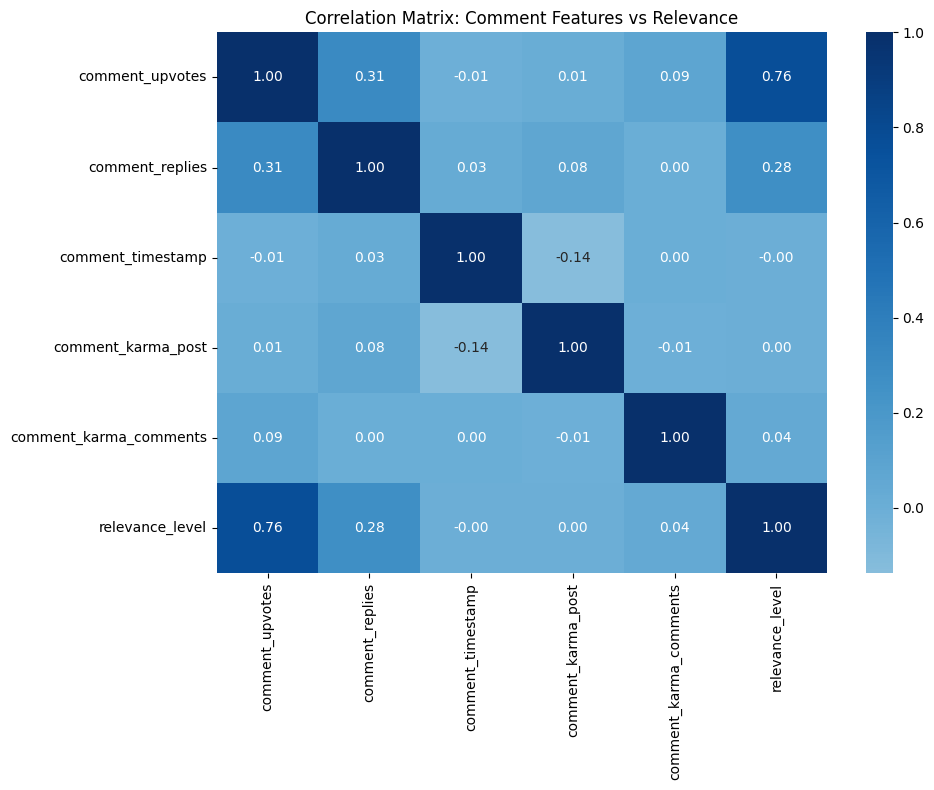

In [ ]:
relevant_qrels = df_qrels

df_comments_renamed = df_comments.rename(columns={
    'upvotes': 'comment_upvotes',
    'replies': 'comment_replies',
    'timestamp': 'comment_timestamp',
    'karma_post': 'comment_karma_post',
    'karma_comments': 'comment_karma_comments'
})

merged = pd.merge(relevant_qrels, df_comments_renamed, on='comment_id', how='inner') # consider same comment_id in df_comments e df_qrels

features = [
    'comment_upvotes',
    'comment_replies',
    'comment_timestamp',
    'comment_karma_post',
    'comment_karma_comments',
    'relevance_level'
]
correlation_df = merged[features].copy()

if pd.api.types.is_datetime64_any_dtype(correlation_df['comment_timestamp']):
    correlation_df['comment_timestamp'] = correlation_df['comment_timestamp'].astype('int64')

corr_matrix = correlation_df.corr(method='pearson')

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="Blues", center=0)
plt.title('Correlation Matrix: Comment Features vs Relevance')
plt.tight_layout()
plt.show()


# **RETRIEVAL MODELS: BM25 and NEURAL RERANKING**

## BASELINE RETRIEVAL (BM25)

BM25 (Best Matching 25) is a probabilistic ranking model that measures the relevance of the comments with respect to a specific post.

- Takes into account the frequency of the term in the document

- Normalizes for the length of the document

- Uses an IDF weight to penalize terms that are too common

In [ ]:
!pip install rank_bm25

In [ ]:
df_posts_bm25 = df_posts.copy()
df_comments_bm25 = df_comments.copy()

In [ ]:
def generate_bm25(df_posts, df_comments, top_k=10):
    stop_words = set(stopwords.words('english'))

    def tokenize(text):
        tokens = word_tokenize(str(text).lower())
        return [t for t in tokens if t.isalnum() and t not in stop_words]

    # Tokenize all comment texts once
    df_comments = df_comments.copy()
    doc_ids = df_comments['comment_id'].tolist()
    doc_texts = df_comments['text'].tolist()
    tokenized_docs = [tokenize(doc) for doc in doc_texts]

    # Build BM25 index once
    bm25 = BM25Okapi(tokenized_docs)

    results_query = []

    for i, row in df_posts.iterrows():
        post_id = row['post_id']
        desc = row['post_description']
        title = row['post_text']
        post_text = title if pd.isna(desc) or not isinstance(desc, str) or not desc.strip() else desc

        # Tokenize query
        query_tokens = tokenize(post_text)

        # Get scores for all documents
        scores = bm25.get_scores(query_tokens)
        scores_norm = MinMaxScaler().fit_transform(np.array(scores).reshape(-1, 1)).flatten()

        top_indices = np.argsort(scores_norm)[::-1][:top_k]
        results = [(doc_ids[idx], scores_norm[idx]) for idx in top_indices]
        results_query.append(results)

    df_posts['Top10_BM25'] = results_query
    return df_posts

In [ ]:
generate_bm25(df_posts_bm25, df_comments_bm25)

,post_id,post_text,post_description,Top10_BM25
0,1izle46,My Dad Left Us 15 Years Ago – Now He’s Dying a...,"When I was 10, my dad walked out on our family...","[(1izle46_mf3uhzd, 1.0), (oev5mz_h48vaf4, 0.84..."
1,1j6z84l,Girlfriend just punched me in the face multipl...,So my longtime girlfriend just had an absolute...,"[(z8vhe1_iyfa7ux, 1.0), (1l7couk_mww7d7f, 0.99..."
2,1hq4eut,My GF is in a medically induced coma and I am ...,\nMy (34M) girlfriend (35F) started having chi...,"[(1hq4eut_m4nb5lb, 1.0), (1hq4eut_m4mx4et, 0.9..."
3,1jxjlxv,Professor has been secretly docking points any...,My professor recently revealed that he’s been ...,"[(1jxjlxv_mmqvx2t, 1.0), (1jxjlxv_mmqv745, 0.8..."
4,1le1rhl,Gf gave me chlamydia,Gf of 6 months just tested positive for chlamy...,"[(1h9mp4i_m12ssxs, 0.9999999999999999), (1le1r..."
...,...,...,...,...
160,1k7umkb,"My brother is a huge creep, how do I get my pa...",My (14F) brother (15M) has down syndrome and i...,"[(1k7umkb_mp1jl01, 1.0), (1k7umkb_mp1hh48, 0.8..."
161,yjqh35,my moms bf strangled me with a belt knowing I ...,My(17f) dad tried to strangle me when I was 13...,"[(yjqh35_iupokfp, 1.0), (yjqh35_iuprdcg, 0.596..."
162,14gfl8g,Pregnant (21f) from a one night stand,I just found out yesterday that I am pregnant ...,"[(mu7x2h_gv50m1v, 1.0), (14gfl8g_jp6tpnx, 0.97..."
163,13zfqvy,Getting Over Hatred of Women,I am a recovering incel. I was never into the ...,"[(13zfqvy_jmsjjny, 1.0), (13zfqvy_jmry8zy, 0.9..."


## NEURAL RERANKING

This technique orders the comments using a neural model to improve relevance.

- A bi-encoder encodes posts and comments separately into dense vectors.
- Cosine similarity between embeddings estimates semantic relevance.
- It captures deeper meanings and context beyond exact term matching.


In [ ]:
#pip install transformers==4.40.1 -qq

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sentence-transformers 5.0.0 requires transformers<5.0.0,>=4.41.0, but you have transformers 4.40.1 which is incompatible.


In [ ]:
df_posts_biencoder = df_posts.copy()
df_comments_biencoder = df_comments.copy()

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')
model = AutoModel.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Mean Pooling to get sentence embeddings
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0]
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, dim=1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

# Batched encoding function
def get_embeddings(texts, batch_size=128):
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        encoded_input = tokenizer(batch, padding=True, truncation=True, return_tensors='pt').to(device)
        with torch.no_grad():
            model_output = model(**encoded_input)
        sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])
        sentence_embeddings = F.normalize(sentence_embeddings, p=2, dim=1)
        embeddings.append(sentence_embeddings.cpu())
    return torch.cat(embeddings, dim=0)

def generate_biencoder(df_posts, df_comments, k=10):
    # Sanitize input if needed
    df_comments = df_comments.copy()

    # Encode all comments once
    comment_ids = df_comments['comment_id'].tolist()
    comment_texts = df_comments['text'].fillna("").astype(str).tolist()
    comment_embeddings = get_embeddings(comment_texts)

    top_answers = []

    for i in tqdm(range(len(df_posts)), desc="Ranking top 10 answers globally per query"):
        post_id = df_posts.loc[i, 'post_id']
        desc = df_posts.loc[i, 'post_description']
        title = df_posts.loc[i, 'post_text']
        post_text = title if pd.isna(desc) or not isinstance(desc, str) or not desc.strip() else desc

        # Encode the query
        query_embedding = get_embeddings([post_text])

        # Compute similarity with all comment embeddings
        similarities = F.cosine_similarity(query_embedding, comment_embeddings).numpy()
        top_k_indices = np.argsort(similarities)[::-1][:k]

        # Get top-k (comment_id, score) pairs
        results = [(comment_ids[idx], similarities[idx]) for idx in top_k_indices]
        top_answers.append(results)

    df_posts['Top10_Biencoder'] = top_answers
    return df_posts

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

In [ ]:
generate_biencoder(df_posts_biencoder, df_comments_biencoder)

Ranking top 10 answers globally per query: 100%|██████████| 165/165 [00:01<00:00, 92.99it/s] 


,post_id,post_text,post_description,Top10_Biencoder
0,1izle46,My Dad Left Us 15 Years Ago – Now He’s Dying a...,"When I was 10, my dad walked out on our family...","[(1izle46_mf3whj8, 0.72008806), (p47jzn_h8xkkt..."
1,1j6z84l,Girlfriend just punched me in the face multipl...,So my longtime girlfriend just had an absolute...,"[(ot4enx_h6tt962, 0.67735136), (15lixy7_jvawjg..."
2,1hq4eut,My GF is in a medically induced coma and I am ...,\nMy (34M) girlfriend (35F) started having chi...,"[(1hq4eut_m4mr5fj, 0.65557724), (1hq4eut_m4mwh..."
3,1jxjlxv,Professor has been secretly docking points any...,My professor recently revealed that he’s been ...,"[(1jxjlxv_mmqvx2t, 0.6595881), (1jxjlxv_mmqxlx..."
4,1le1rhl,Gf gave me chlamydia,Gf of 6 months just tested positive for chlamy...,"[(1le1rhl_myctmui, 0.7128423), (1le1rhl_mycr3t..."
...,...,...,...,...
160,1k7umkb,"My brother is a huge creep, how do I get my pa...",My (14F) brother (15M) has down syndrome and i...,"[(1k7umkb_mp2o1t8, 0.6880902), (1e7usn0_le3acw..."
161,yjqh35,my moms bf strangled me with a belt knowing I ...,My(17f) dad tried to strangle me when I was 13...,"[(y2bnqs_is2d1t2, 0.6936012), (y2bnqs_is2b3li,..."
162,14gfl8g,Pregnant (21f) from a one night stand,I just found out yesterday that I am pregnant ...,"[(r0cadi_hls7dsp, 0.72883964), (p47jzn_h8x7skk..."
163,13zfqvy,Getting Over Hatred of Women,I am a recovering incel. I was never into the ...,"[(13zfqvy_jmry8zy, 0.7983928), (13zfqvy_jmrujo..."


# **FUNCTIONS for EVALUATION METRICS**

## PRECISION and RECALL

**Precision**

This metric measures the proportion of retrieved documents that are actually relevant.

- It focuses on the quality of the top results returned by the system.
- A high precision means few irrelevant documents were retrieved.
- It does not consider how many relevant documents were missed.
- The value ranges from 0 to 1, where 1 means all retrieved documents are relevant.

---

**Recall**

This metric measures the proportion of all relevant documents that were successfully retrieved.

- It evaluates how completely the system finds the relevant information.
- A high recall means most or all relevant documents were retrieved.
- It does not penalize the inclusion of irrelevant documents.
- The value ranges from 0 to 1, where 1 means all relevant documents were retrieved.


In [ ]:
def compute_precision_recall_at_k(df_queries, df_qrels, column_ranking, k=5):
    precisions = []
    recalls = []

    for _, row in df_queries.iterrows():
        post_id = row['post_id']
        ranked_docs = [doc_id for doc_id, _ in row[column_ranking]][:k]
        relevant_docs = set(df_qrels[(df_qrels['post_id'] == post_id) & (df_qrels['relevance_level'].isin([3, 4]))]['comment_id'])

        if not relevant_docs:
            continue

        hits = sum(1 for doc_id in ranked_docs if doc_id in relevant_docs)

        precision = hits / k
        recall = hits / len(relevant_docs)

        precisions.append(precision)
        recalls.append(recall)

    avg_precision = np.mean(precisions) if precisions else 0.0
    avg_recall = np.mean(recalls) if recalls else 0.0

    return avg_precision, avg_recall

In [ ]:
def plot_precision_recall(my_dataframe, df_qrels_clean, BM25_or_biencoder_column, k=10):

    ks = list(range(1, k))
    precs = []
    recs  = []
    for i in ks:
        p, r = compute_precision_recall_at_k(my_dataframe, df_qrels_clean, BM25_or_biencoder_column, k=i)
        precs.append(p)
        recs.append(r)

    plt.figure(figsize=(8, 4))
    plt.plot(ks, precs, marker='o', label='Precision')
    plt.plot(ks, recs,  marker='s', label='Recall')
    plt.xlabel('k (number of queries)')
    plt.ylabel('Average score')
    plt.title('Precision and Recall trends as k varies')
    plt.xticks(ks)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## MAP

This metric measures the overall precision of a ranking system across multiple queries.

- It calculates the average precision for each query individually.
- It considers the order of relevant documents, rewarding those retrieved earlier.
- The final score is the mean of all average precisions, providing a single effectiveness value.
- The value ranges from 0 to 1, where 1 indicates that all relevant documents are ranked at the top for every query.


In [ ]:
def compute_map_at_k(df_queries, df_qrels, column_ranking, k=5):
    average_precisions = []

    for _, row in df_queries.iterrows():
        post_id = row['post_id']
        ranked_docs = [doc_id for doc_id, _ in row[column_ranking]][:k]
        relevant_docs = set(df_qrels[(df_qrels['post_id'] == post_id) & (df_qrels['relevance_level'].isin([3, 4]))]['comment_id'])

        num_hits = 0
        precision_sum = 0.0

        for i, doc_id in enumerate(ranked_docs, start=1):
            if doc_id in relevant_docs:
                num_hits += 1
                precision_sum += num_hits / i

        if num_hits > 0:
            ap = precision_sum / num_hits
            average_precisions.append(ap)

    return np.mean(average_precisions) if average_precisions else 0.0

In [ ]:
def plot_map_curve_iterative(df_queries, df_qrels, column_ranking, k_max=5):
    ks = list(range(1, k_max + 1))
    map_scores = []

    for k in ks:
        score = compute_map_at_k(df_queries, df_qrels, column_ranking, k)
        map_scores.append(score)

    plt.figure(figsize=(8, 5))
    plt.plot(ks, map_scores, marker='o', color='green', label='MAP@k')
    plt.xlabel('k (cut-off)')
    plt.ylabel('Mean Average Precision')
    plt.title('MAP trend as k changes')
    plt.xticks(ks)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

## nDCG

This metric indicates how well a system ranks relevant documents at the top of the results list.

- It takes into account the relevance of documents.

- It penalizes relevant documents if they appear in lower positions.

- The value is normalized between 0 and 1, where 1 represents a perfect ranking.

In [ ]:
def compute_ndcg_at_k(df_queries, df_qrels, column_ranking, k=5):
    ndcg_scores = []

    for _, row in df_queries.iterrows():
        post_id = row['post_id']
        ranked_docs = [doc_id for doc_id, _ in row[column_ranking]][:k]

        qrels = df_qrels[df_qrels['post_id'] == post_id]
        relevance = dict(zip(qrels['comment_id'], qrels['relevance_level']))

        gains = [relevance.get(doc_id, 0) for doc_id in ranked_docs]

        if not any(gains):
            continue  #Skip queries with no relevant documents

        #Ideal ranking (sorted by relevance)
        ideal_gains = sorted(relevance.values(), reverse=True)[:k]

        dcg = sum(gain / np.log2(i + 2) for i, gain in enumerate(gains))
        idcg = sum(gain / np.log2(i + 2) for i, gain in enumerate(ideal_gains))

        ndcg = dcg / idcg if idcg > 0 else 0.0
        ndcg_scores.append(ndcg)

    return np.mean(ndcg_scores) if ndcg_scores else 0.0

In [ ]:
def plot_ndcg_curve(df_queries, df_qrels, column_ranking, k_max=5):
    ks = list(range(1, k_max + 1))
    ndcg_scores = []

    for k in ks:
        score = compute_ndcg_at_k(df_queries, df_qrels, column_ranking, k)
        ndcg_scores.append(score)

    plt.figure(figsize=(8, 5))
    plt.plot(ks, ndcg_scores, marker='s', color='blue', label='nDCG@k')
    plt.xlabel('k (cut-off)')
    plt.ylabel('Normalized DCG')
    plt.title('nDCG trend as k changes')
    plt.xticks(ks)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# **EVALUATION METRICS**

## **BM25**

### PRECISION and RECALL

In [ ]:
compute_precision_recall_at_k(df_posts_bm25, df_qrels_fin, 'Top10_BM25', k=5)

(np.float64(0.14545454545454545), np.float64(0.14545454545454545))

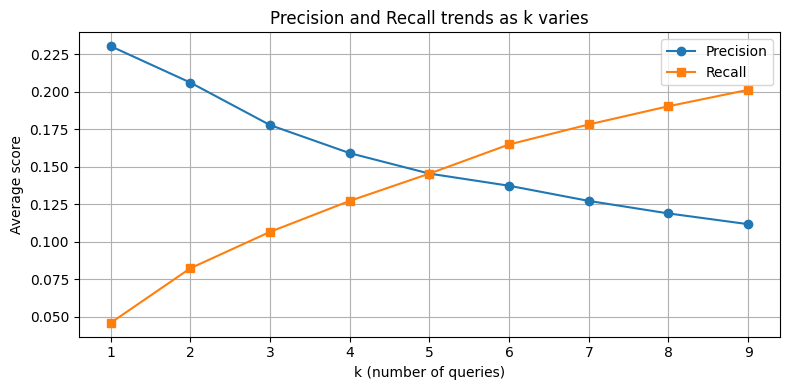

In [ ]:
plot_precision_recall(df_posts_bm25, df_qrels_fin, 'Top10_BM25')

### MAP

In [ ]:
compute_map_at_k(df_posts_bm25, df_qrels_fin, 'Top10_BM25')

np.float64(0.6316214470284238)

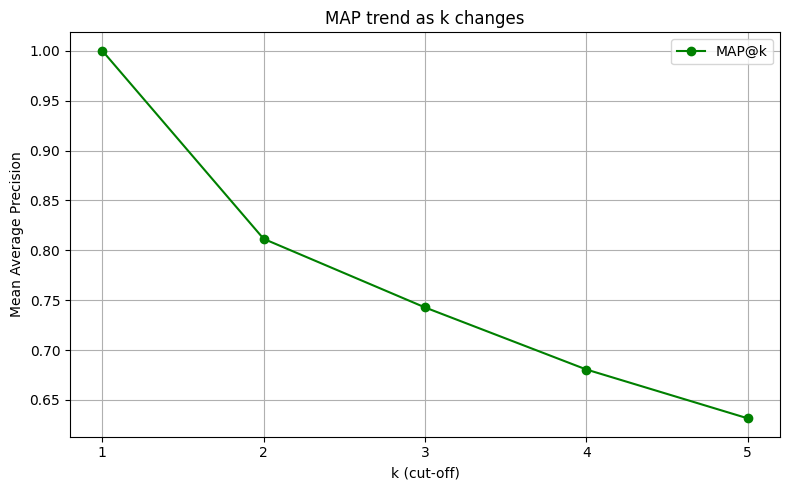

In [ ]:
plot_map_curve_iterative(df_posts_bm25, df_qrels_fin, 'Top10_BM25')

### nDCG

In [ ]:
compute_ndcg_at_k(df_posts_bm25, df_qrels_fin, 'Top10_BM25')

np.float64(0.31403637159360065)

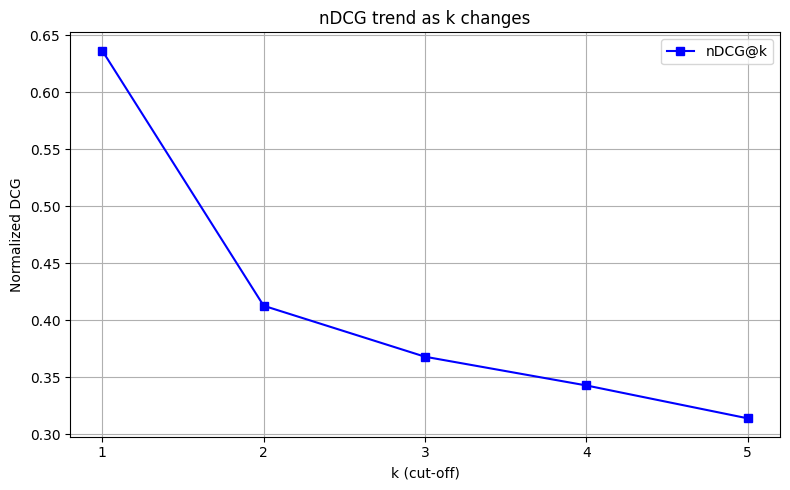

In [ ]:
plot_ndcg_curve(df_posts_bm25, df_qrels_fin, 'Top10_BM25')

## **NEURAL RERANKING**

### PRECISION and RECALL

In [ ]:
compute_precision_recall_at_k(df_posts_biencoder, df_qrels_fin, 'Top10_Biencoder', k=5)

(np.float64(0.18060606060606058), np.float64(0.18060606060606058))

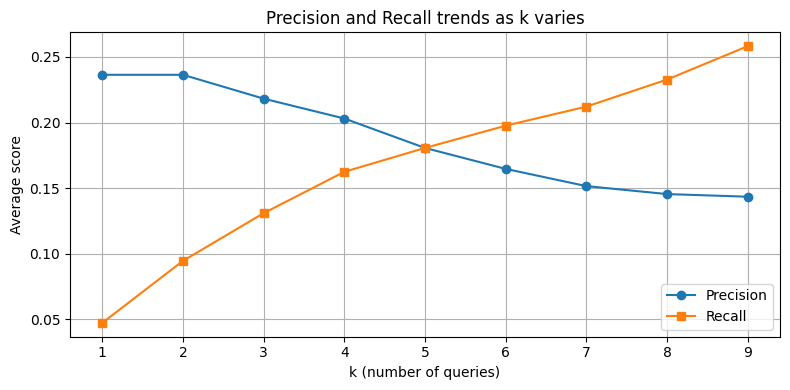

In [ ]:
plot_precision_recall(df_posts_biencoder, df_qrels_fin, 'Top10_Biencoder')

### MAP

In [ ]:
compute_map_at_k(df_posts_biencoder, df_qrels_fin, 'Top10_Biencoder')

np.float64(0.6223404255319149)

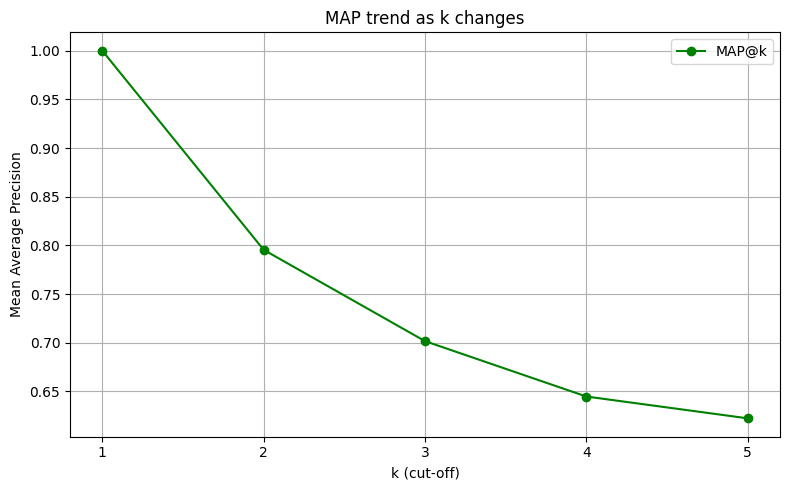

In [ ]:
plot_map_curve_iterative(df_posts_biencoder, df_qrels_fin, 'Top10_Biencoder')

### nDCG

In [ ]:
compute_ndcg_at_k(df_posts_biencoder, df_qrels_fin, 'Top10_Biencoder')

np.float64(0.35556157605632055)

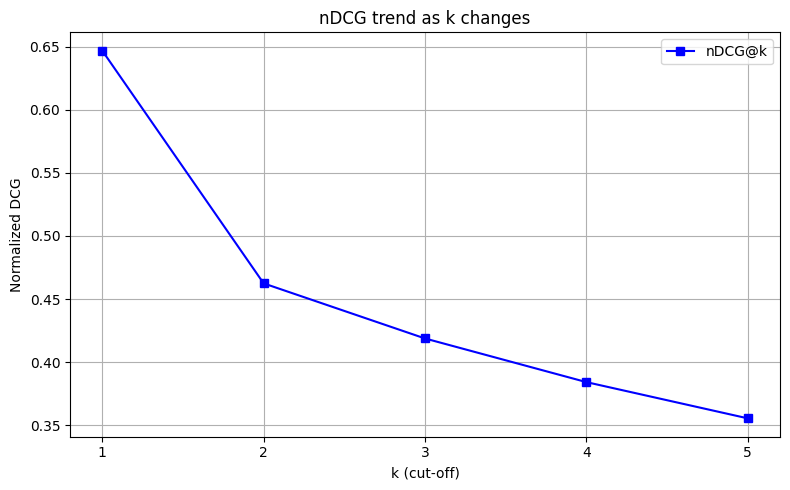

In [ ]:
plot_ndcg_curve(df_posts_biencoder, df_qrels_fin, 'Top10_Biencoder')